In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import datetime

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,CuDNNLSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import plot_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

%matplotlib inline

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
MODELS_DIR='j_models'

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [4]:
torch.manual_seed(42)

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
np.random.seed(42)

In [7]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)

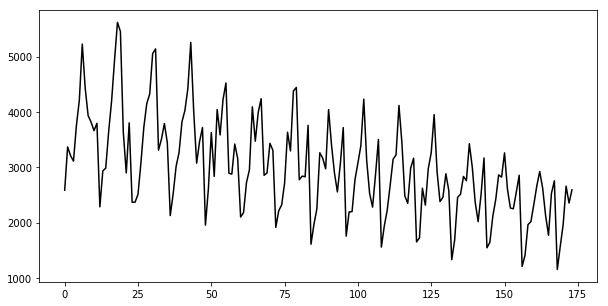

In [8]:
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.show()

In [9]:
def split_signal(inpt, length, batch_size, sclr, show=False):
    f = sclr.fit_transform(inpt)
    f_tr = f[:batch_size]
    f_test = f[batch_size-length:]
    if show:
        plt.figure(figsize = (10, 5))
        plt.plot(f, 'k')
        plt.plot(np.r_[:batch_size],f_tr, 'b')
        plt.plot(np.r_[batch_size-length:len(inpt)],f_test, 'r')
        plt.show()

        print(f_tr.shape[0], f_test.shape[0])
    return f_tr, f_test

In [10]:
def get_ts(source, length, batch_size):
    data_gen = TimeseriesGenerator(source, source,
                                 length=length, sampling_rate=1,
                                 batch_size=batch_size)
    x, yy = data_gen[0]
    xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
#     print(xx.shape)
#     print(yy.shape)
    return torch.Tensor(xx), yy

In [11]:
class TSDataSet(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
         
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, i):
        
        return torch.from_numpy(self.inputs[i]).unsqueeze(-1).float(), torch.Tensor([self.targets[i]]).squeeze().float()

In [12]:
def get_dataset(inpt, length):
    F_t=F_tr.ravel().astype(np.float)
    F_data=np.array([[F_t[i:i+length+1][:-1],F_t[i:i+length+1][-1]] for i in range(len(F_tr)-length)])
    return TSDataSet(F_data[:,0],F_data[:,1])

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

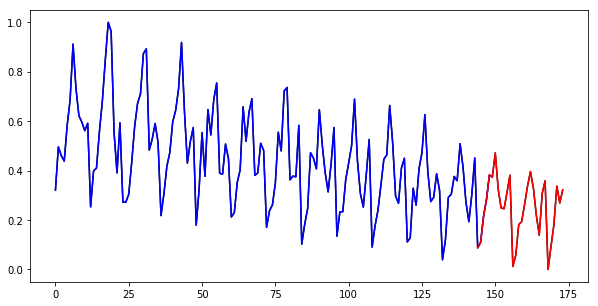

150 30


In [14]:
F_tr, F_test = split_signal(Fort, 6, 150, scaler, True)

In [15]:
train_xx, train_yy = get_ts(F_tr, 6, 150)

In [16]:
test_xx, test_yy = get_ts(F_test, 6, 150)

In [17]:
train_set=get_dataset(F_tr,6)

In [18]:
batch_size=1
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [19]:
class Net(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, drpout=None):
        super(Net, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.drpout = drpout
        
        if not self.drpout:
            self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim) 
            self.fc1 = nn.Linear(self.hidden_dim, 1)
        else:
            self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim)
            self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim)
            self.lstm3 = nn.LSTM(self.hidden_dim, self.hidden_dim)
            self.fc1 = nn.Linear(self.hidden_dim, 1)
            
            self.dropout = nn.Dropout(0.5) 

    def init_hidden(self):
        return (torch.zeros(2, self.batch_size, self.hidden_dim),
                torch.zeros(2, self.batch_size, self.hidden_dim))

    def forward(self, x): 
        if not self.drpout:
            x, self.hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
            x = self.fc1(x[-1].view(self.batch_size, -1))
        else:
            x, self.hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
            x = self.dropout(x)
            x, self.hidden = self.lstm2(x.view(len(x), self.batch_size, -1))
            x = self.dropout(x)
            x, self.hidden = self.lstm3(x.view(len(x), self.batch_size, -1))
            x = self.fc1(x[-1].view(self.batch_size, -1))
        
        return x.view(-1)

In [20]:
net = Net(batch_size, 6, 20, 0.2).to(device)
net

Net(
  (lstm1): LSTM(6, 20)
  (lstm2): LSTM(20, 20)
  (lstm3): LSTM(20, 20)
  (fc1): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters())

In [22]:
for epoch in range(100):   
    net.hidden = net.init_hidden()
    for i, data in enumerate(train_loader):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print('epoch %d, training loss: %.3f' %
          (epoch+1, loss.item()))

print('finish')

epoch 10, training loss: 0.036
epoch 20, training loss: 0.019
epoch 30, training loss: 0.070
epoch 40, training loss: 0.001
epoch 50, training loss: 0.017
epoch 60, training loss: 0.000
epoch 70, training loss: 0.021
epoch 80, training loss: 0.127
epoch 90, training loss: 0.072
epoch 100, training loss: 0.009
finish


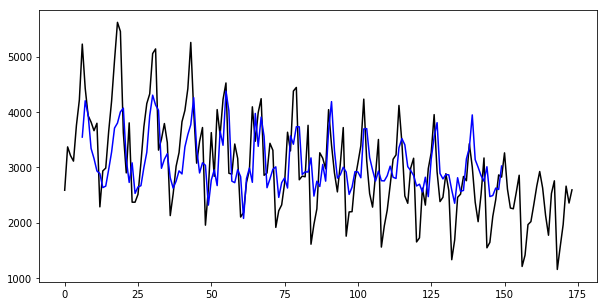

In [23]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

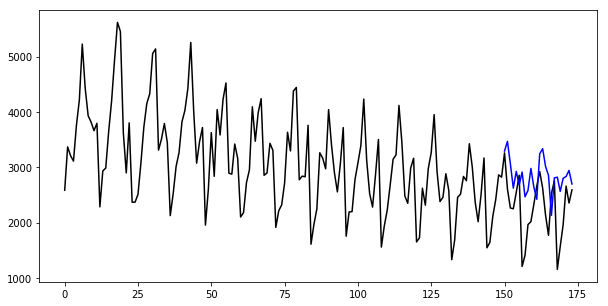

In [24]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()

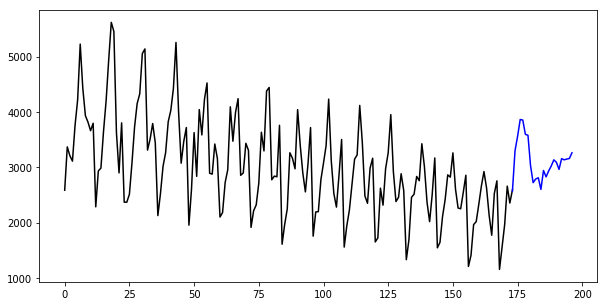

In [25]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
plt.show()

In [26]:
def train(inpt, epchs, f_msk, **kwargs):
    start=datetime.datetime.now()
    
    delay=kwargs['delay']
    neuron=kwargs['neuron']
    btch_sz=kwargs['btch_sz']
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    F_tr, F_test = split_signal(inpt, delay, btch_sz, scaler)
    train_xx, train_yy = get_ts(F_tr, delay, btch_sz)
    test_xx, test_yy = get_ts(F_test, delay, btch_sz)
    train_set=get_dataset(F_tr,delay)
    batch_size=1
    train_loader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    net = Net(batch_size, delay, neuron, kwargs.get('drpout')).to(device)



    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters())

    train_mse=[]
    test_mse=[]
    
    for epoch in range(epochs):
        net.train()
        net.hidden = net.init_hidden()
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

#         if (epoch + 1) % 10 == 0:
#             print('epoch %d, training loss: %.3f' %
#               (epoch+1, loss.item()))

        net.eval()

        pred_train=[]
        for i in range(len(train_xx)):
            out=net(train_xx[i].unsqueeze(-1).to(device))
            pred_train.append(out.detach().cpu().item())
        pred_train=np.array(pred_train)

        pred_test=[]
        for i in range(len(test_xx)):
            out=net(test_xx[i].unsqueeze(-1).to(device))
            pred_test.append(out.detach().cpu().item())
        pred_test=np.array(pred_test)

        train_mse.append(mean_squared_error(train_yy,pred_train))
        test_mse.append(mean_squared_error(test_yy,pred_test))

    
    state = {
        'state': net.state_dict(),
        'train_mse': train_mse,
        'test_mse': test_mse
    }    
    torch.save(state, '{}_{}.t7'.format(file_mask, '_'.join([str(kwargs[k]) for k in kwargs])))  

    end=datetime.datetime.now()-start

    print('{} {} train_mse={:.3f} test_mse={:.3f}'.format(end, ' '.join(['{}={}'.format(k, kwargs[k]) for k in kwargs]), train_mse[-1], test_mse[-1]))
    
    return train_mse[-1], test_mse[-1], end

# Training

In [33]:
delays=[1,2,3,6,12]
neurons=[20,25,30,35,40,45,50]
batch_sizes=[100,125,150]
dropouts=[0.1,0.2,0.3]

In [34]:
epochs=100
file_mask=MODELS_DIR+'\\simple_fort_model'
simple_fort_model_result=pd.DataFrame()

In [35]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            train_mse, test_mse, end=train(Fort, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz)
            simple_fort_model_result=simple_fort_model_result.append([[delay, neuron, btch_sz, train_mse, test_mse, end]], ignore_index=True)
simple_fort_model_result.columns=['delay', 'neuron','btch_sz', 'train_mse', 'test_mse', 'time']
simple_fort_model_result=simple_fort_model_result.sort_values(['test_mse'])
simple_fort_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:20.932040 delay=1 neuron=20 btch_sz=100 train_mse=0.025 test_mse=0.020
0:00:20.840092 delay=1 neuron=20 btch_sz=125 train_mse=0.026 test_mse=0.016
0:00:20.892062 delay=1 neuron=20 btch_sz=150 train_mse=0.023 test_mse=0.020
0:00:21.005996 delay=1 neuron=25 btch_sz=100 train_mse=0.025 test_mse=0.019
0:00:21.094947 delay=1 neuron=25 btch_sz=125 train_mse=0.025 test_mse=0.018
0:00:21.023988 delay=1 neuron=25 btch_sz=150 train_mse=0.024 test_mse=0.022
0:00:21.211879 delay=1 neuron=30 btch_sz=100 train_mse=0.025 test_mse=0.024
0:00:21.201885 delay=1 neuron=30 btch_sz=125 train_mse=0.026 test_mse=0.016
0:00:21.290835 delay=1 neuron=30 btch_sz=150 train_mse=0.023 test_mse=0.019
0:00:21.767562 delay=1 neuron=35 btch_sz=100 train_mse=0.025 test_mse=0.025
0:00:21.737579 delay=1 neuron=35 btch_sz=125 train_mse=0.027 test_mse=0.015
0:00:21.768562 delay=1 neuron=35 btch_sz=150 train_mse=0.023 test_mse=0.020
0:00:22.102371 delay=1 neuron=40 btch_sz=100 train_mse=0.025 test_mse=0.022
0:00:21.9304

In [36]:
epochs=100
file_mask=MODELS_DIR+'\\complex_fort_model'
complex_fort_model_result=pd.DataFrame()

In [37]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            for drpout in dropouts:
                train_mse, test_mse, end=train(Fort, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz, drpout=drpout)
                complex_fort_model_result=complex_fort_model_result.append([[delay, neuron, btch_sz, drpout, train_mse, test_mse, end]], ignore_index=True)
complex_fort_model_result.columns=['delay', 'neuron','btch_sz', 'drpout', 'train_mse', 'test_mse', 'time']
complex_fort_model_result=complex_fort_model_result.sort_values(['test_mse'])
complex_fort_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:49.717593 delay=1 neuron=20 btch_sz=100 drpout=0.1 train_mse=0.025 test_mse=0.023
0:00:49.734583 delay=1 neuron=20 btch_sz=100 drpout=0.2 train_mse=0.026 test_mse=0.020
0:00:50.440179 delay=1 neuron=20 btch_sz=100 drpout=0.3 train_mse=0.026 test_mse=0.020
0:00:49.863509 delay=1 neuron=20 btch_sz=125 drpout=0.1 train_mse=0.026 test_mse=0.027
0:00:49.932470 delay=1 neuron=20 btch_sz=125 drpout=0.2 train_mse=0.025 test_mse=0.024
0:00:49.752572 delay=1 neuron=20 btch_sz=125 drpout=0.3 train_mse=0.025 test_mse=0.022
0:00:49.936468 delay=1 neuron=20 btch_sz=150 drpout=0.1 train_mse=0.025 test_mse=0.017
0:00:50.047403 delay=1 neuron=20 btch_sz=150 drpout=0.2 train_mse=0.025 test_mse=0.018
0:00:49.979442 delay=1 neuron=20 btch_sz=150 drpout=0.3 train_mse=0.024 test_mse=0.023
0:00:50.721018 delay=1 neuron=25 btch_sz=100 drpout=0.1 train_mse=0.026 test_mse=0.021
0:00:50.555113 delay=1 neuron=25 btch_sz=100 drpout=0.2 train_mse=0.025 test_mse=0.022
0:00:50.667049 delay=1 neuron=25 btch_sz=10

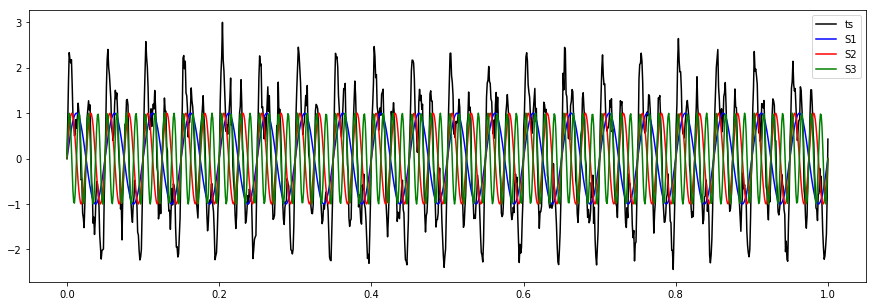

In [27]:
t = np.linspace(0, 1, 1024)

#линейная частота сезона
f = 10 #P = 1/10

S1 = np.sin(2*np.pi*2*f*t)
S2 = np.sin(2*np.pi*4*f*t)
S3 = np.sin(2*np.pi*8*f*t)

noise = 0.2*np.random.randn(len(t))

F_lab = S1 + S2 + S3 + noise
F_lab=F_lab.reshape(-1,1)

N = 1024

plt.figure(figsize = (15, 5))
plt.plot(t, F_lab, 'k', label = 'ts')
plt.plot(t, S1, 'b', label = 'S1')
plt.plot(t, S2, 'r', label = 'S2')
plt.plot(t, S3, 'g', label = 'S3')
plt.legend()
plt.show()

In [28]:
delays=[6,12]
neurons=[10,20,25,30,35,40]
batch_sizes=[800,850,900]
dropouts=[0.1,0.2,0.3]

In [29]:
epochs=100
file_mask=MODELS_DIR+'\\simple_lab_model'
simple_lab_model_result=pd.DataFrame()

In [30]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            train_mse, test_mse, end=train(F_lab, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz)
            simple_lab_model_result=simple_lab_model_result.append([[delay, neuron, btch_sz, train_mse, test_mse, end]], ignore_index=True)
simple_lab_model_result.columns=['delay', 'neuron','btch_sz', 'train_mse', 'test_mse', 'time']
simple_lab_model_result=simple_lab_model_result.sort_values(['test_mse'])
simple_lab_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:46.064772 delay=6 neuron=10 btch_sz=800 train_mse=0.015 test_mse=0.014
0:00:48.158652 delay=6 neuron=10 btch_sz=850 train_mse=0.016 test_mse=0.015
0:00:49.069306 delay=6 neuron=10 btch_sz=900 train_mse=0.014 test_mse=0.013
0:00:51.013732 delay=6 neuron=20 btch_sz=800 train_mse=0.014 test_mse=0.013
0:00:50.329218 delay=6 neuron=20 btch_sz=850 train_mse=0.014 test_mse=0.013
0:00:51.420891 delay=6 neuron=20 btch_sz=900 train_mse=0.015 test_mse=0.013
0:00:50.670023 delay=6 neuron=25 btch_sz=800 train_mse=0.017 test_mse=0.016
0:00:51.640025 delay=6 neuron=25 btch_sz=850 train_mse=0.013 test_mse=0.012
0:00:50.401046 delay=6 neuron=25 btch_sz=900 train_mse=0.019 test_mse=0.016
0:00:51.101025 delay=6 neuron=30 btch_sz=800 train_mse=0.014 test_mse=0.013
0:00:50.931025 delay=6 neuron=30 btch_sz=850 train_mse=0.015 test_mse=0.014
0:00:52.737062 delay=6 neuron=30 btch_sz=900 train_mse=0.014 test_mse=0.013
0:00:52.450016 delay=6 neuron=35 btch_sz=800 train_mse=0.013 test_mse=0.013
0:00:52.2701

In [31]:
epochs=100
file_mask=MODELS_DIR+'\\complex_lab_model'
complex_lab_model_result=pd.DataFrame()

In [32]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            for drpout in dropouts:
                train_mse, test_mse, end=train(F_lab, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz, drpout=drpout)
                complex_lab_model_result=complex_lab_model_result.append([[delay, neuron, btch_sz, drpout, train_mse, test_mse, end]], ignore_index=True)
complex_lab_model_result.columns=['delay', 'neuron','btch_sz', 'drpout', 'train_mse', 'test_mse', 'time']
complex_lab_model_result=complex_lab_model_result.sort_values(['test_mse'])
complex_lab_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:02:04.989120 delay=6 neuron=10 btch_sz=800 drpout=0.1 train_mse=0.017 test_mse=0.016
0:02:02.148468 delay=6 neuron=10 btch_sz=800 drpout=0.2 train_mse=0.017 test_mse=0.017
0:02:04.750826 delay=6 neuron=10 btch_sz=800 drpout=0.3 train_mse=0.019 test_mse=0.018
0:02:03.114556 delay=6 neuron=10 btch_sz=850 drpout=0.1 train_mse=0.015 test_mse=0.015
0:02:06.705127 delay=6 neuron=10 btch_sz=850 drpout=0.2 train_mse=0.015 test_mse=0.014
0:02:04.881167 delay=6 neuron=10 btch_sz=850 drpout=0.3 train_mse=0.018 test_mse=0.017
0:02:02.314607 delay=6 neuron=10 btch_sz=900 drpout=0.1 train_mse=0.017 test_mse=0.016
0:02:06.255405 delay=6 neuron=10 btch_sz=900 drpout=0.2 train_mse=0.019 test_mse=0.017
0:02:03.515672 delay=6 neuron=10 btch_sz=900 drpout=0.3 train_mse=0.017 test_mse=0.015
0:02:06.041143 delay=6 neuron=20 btch_sz=800 drpout=0.1 train_mse=0.017 test_mse=0.016
0:02:04.817013 delay=6 neuron=20 btch_sz=800 drpout=0.2 train_mse=0.017 test_mse=0.016
0:02:11.585386 delay=6 neuron=20 btch_sz=80

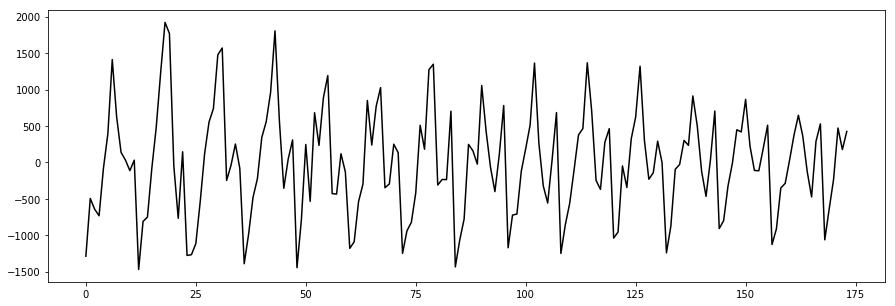

In [38]:
F_trendless=Fort.ravel()-[-9.8576*x + 3872.7 for x in range(174)]
F_trendless=F_trendless.reshape(-1,1)

plt.figure(figsize = (15, 5))
plt.plot(F_trendless, 'k')
plt.show()

In [39]:
delays=[1,2,3,6,12]
neurons=[10,20,25,30,35,40]
batch_sizes=[100,125,150]
dropouts=[0.1,0.2,0.3]

In [40]:
epochs=100
file_mask=MODELS_DIR+'\\simple_fort_trendless_model'
simple_fort_trendless_model_result=pd.DataFrame()

In [41]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            train_mse, test_mse, end=train(F_trendless, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz)
            simple_fort_trendless_model_result=simple_fort_trendless_model_result.append([[delay, neuron, btch_sz, train_mse, test_mse, end]], ignore_index=True)
simple_fort_trendless_model_result.columns=['delay', 'neuron','btch_sz', 'train_mse', 'test_mse', 'time']
simple_fort_trendless_model_result=simple_fort_trendless_model_result.sort_values(['test_mse'])
simple_fort_trendless_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:20.782126 delay=1 neuron=10 btch_sz=100 train_mse=0.044 test_mse=0.030
0:00:20.718160 delay=1 neuron=10 btch_sz=125 train_mse=0.041 test_mse=0.025
0:00:20.714163 delay=1 neuron=10 btch_sz=150 train_mse=0.038 test_mse=0.023
0:00:20.937036 delay=1 neuron=20 btch_sz=100 train_mse=0.042 test_mse=0.028
0:00:20.894061 delay=1 neuron=20 btch_sz=125 train_mse=0.041 test_mse=0.024
0:00:21.232866 delay=1 neuron=20 btch_sz=150 train_mse=0.038 test_mse=0.023
0:00:21.255854 delay=1 neuron=25 btch_sz=100 train_mse=0.042 test_mse=0.028
0:00:21.001999 delay=1 neuron=25 btch_sz=125 train_mse=0.041 test_mse=0.024
0:00:34.896061 delay=1 neuron=25 btch_sz=150 train_mse=0.038 test_mse=0.024
0:00:21.247858 delay=1 neuron=30 btch_sz=100 train_mse=0.042 test_mse=0.028
0:00:21.212878 delay=1 neuron=30 btch_sz=125 train_mse=0.040 test_mse=0.024
0:00:21.253856 delay=1 neuron=30 btch_sz=150 train_mse=0.038 test_mse=0.023
0:00:21.746574 delay=1 neuron=35 btch_sz=100 train_mse=0.042 test_mse=0.029
0:00:21.7315

In [42]:
epochs=100
file_mask=MODELS_DIR+'\\complex_fort_trendless_model'
complex_fort_trendless_model_result=pd.DataFrame()

In [43]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            for drpout in dropouts:
                train_mse, test_mse, end=train(F_trendless, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz, drpout=drpout)
                complex_fort_trendless_model_result=complex_fort_trendless_model_result.append([[delay, neuron, btch_sz, drpout, train_mse, test_mse, end]], ignore_index=True)
complex_fort_trendless_model_result.columns=['delay', 'neuron','btch_sz', 'drpout', 'train_mse', 'test_mse', 'time']
complex_fort_trendless_model_result=complex_fort_trendless_model_result.sort_values(['test_mse'])
complex_fort_trendless_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:49.593663 delay=1 neuron=10 btch_sz=100 drpout=0.1 train_mse=0.042 test_mse=0.028
0:00:49.843521 delay=1 neuron=10 btch_sz=100 drpout=0.2 train_mse=0.041 test_mse=0.027
0:00:49.641635 delay=1 neuron=10 btch_sz=100 drpout=0.3 train_mse=0.042 test_mse=0.028
0:00:49.791550 delay=1 neuron=10 btch_sz=125 drpout=0.1 train_mse=0.041 test_mse=0.025
0:00:49.781555 delay=1 neuron=10 btch_sz=125 drpout=0.2 train_mse=0.040 test_mse=0.024
0:00:49.973446 delay=1 neuron=10 btch_sz=125 drpout=0.3 train_mse=0.040 test_mse=0.024
0:00:49.734582 delay=1 neuron=10 btch_sz=150 drpout=0.1 train_mse=0.037 test_mse=0.023
0:00:50.149346 delay=1 neuron=10 btch_sz=150 drpout=0.2 train_mse=0.038 test_mse=0.024
0:00:49.713595 delay=1 neuron=10 btch_sz=150 drpout=0.3 train_mse=0.038 test_mse=0.024
0:00:51.031842 delay=1 neuron=20 btch_sz=100 drpout=0.1 train_mse=0.042 test_mse=0.028
0:00:51.227729 delay=1 neuron=20 btch_sz=100 drpout=0.2 train_mse=0.042 test_mse=0.029
0:00:51.047832 delay=1 neuron=20 btch_sz=10

# Torch results

In [44]:
simple_fort_model_result.head()

,delay,neuron,btch_sz,train_mse,test_mse,time
98,12,40,150,0.005610,0.002398,00:00:21.121931
86,12,20,150,0.005764,0.002540,00:00:19.759708
104,12,50,150,0.006020,0.002547,00:00:21.478726
95,12,35,150,0.005508,0.002550,00:00:20.524272
89,12,25,150,0.005779,0.002641,00:00:19.675757


In [45]:
complex_fort_model_result.head()

,delay,neuron,btch_sz,drpout,train_mse,test_mse,time
287,12,35,150,0.3,0.006103,0.002778,00:00:50.929899
303,12,45,150,0.1,0.005702,0.003022,00:00:52.832812
307,12,50,100,0.2,0.007393,0.003079,00:00:53.868222
305,12,45,150,0.3,0.006180,0.003108,00:00:54.253001
296,12,40,150,0.3,0.005956,0.003138,00:00:51.536552


In [46]:
simple_lab_model_result.head()

,delay,neuron,btch_sz,train_mse,test_mse,time
17,6,40,900,0.012590,0.011762,00:00:53.255088
7,6,25,850,0.012917,0.012275,00:00:51.640025
12,6,35,800,0.012925,0.012503,00:00:52.450016
2,6,10,900,0.013831,0.012604,00:00:49.069306
11,6,30,900,0.014059,0.012624,00:00:52.737062


In [47]:
complex_lab_model_result.head()

,delay,neuron,btch_sz,drpout,train_mse,test_mse,time
45,6,40,800,0.1,0.012779,0.012522,00:01:54.278706
42,6,35,900,0.1,0.013744,0.012989,00:01:54.699478
18,6,25,800,0.1,0.013754,0.013247,00:01:58.114222
39,6,35,850,0.1,0.014063,0.013676,00:01:52.664627
16,6,20,900,0.2,0.013998,0.013688,00:02:08.251066


In [48]:
simple_fort_trendless_model_result.head()

,delay,neuron,btch_sz,train_mse,test_mse,time
83,12,30,150,0.009422,0.004619,00:00:20.210451
84,12,35,100,0.011830,0.004901,00:00:20.949030
86,12,35,150,0.010048,0.005036,00:00:21.150915
73,12,10,125,0.010525,0.005078,00:00:19.608795
78,12,25,100,0.011997,0.005204,00:00:20.406340


In [49]:
complex_fort_trendless_model_result.head()

,delay,neuron,btch_sz,drpout,train_mse,test_mse,time
269,12,40,150,0.3,0.010023,0.004727,00:00:49.965451
267,12,40,150,0.1,0.010501,0.004819,00:00:49.506713
242,12,25,150,0.3,0.010664,0.004906,00:00:48.126501
232,12,20,150,0.2,0.010461,0.004989,00:00:47.677759
240,12,25,150,0.1,0.010314,0.005033,00:00:48.102515


## Fort simple model

In [50]:
delay=simple_fort_model_result.head(1)['delay'].values[0]
neuron=simple_fort_model_result.head(1)['neuron'].values[0]
train_size=simple_fort_model_result.head(1)['btch_sz'].values[0]

In [51]:
checkpoint=torch.load(MODELS_DIR+'\\simple_fort_model_{}_{}_{}.t7'.format(delay,neuron,train_size))

net=Net(1, delay, neuron).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

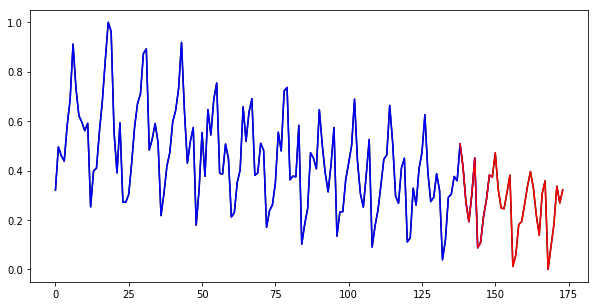

150 36


In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(Fort, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

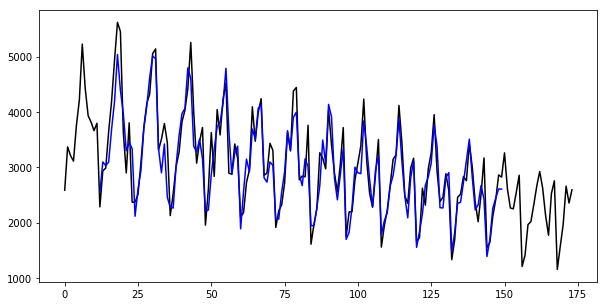

In [53]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

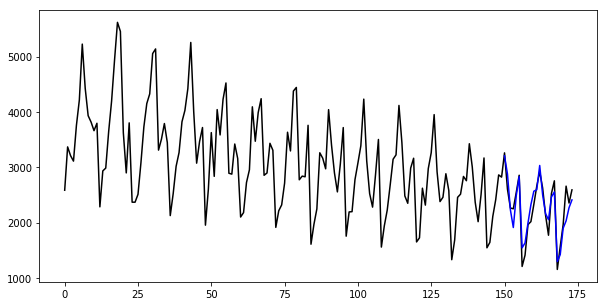

In [54]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[train_size:len(Fort)],testPredict, 'b')
plt.show()

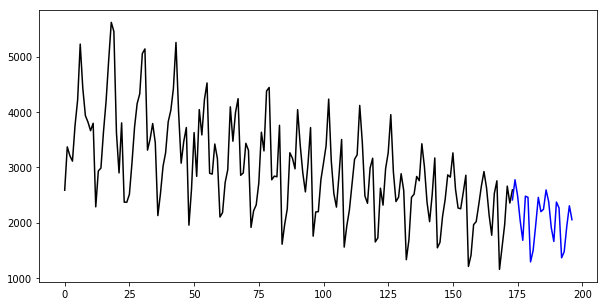

In [55]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
plt.show()

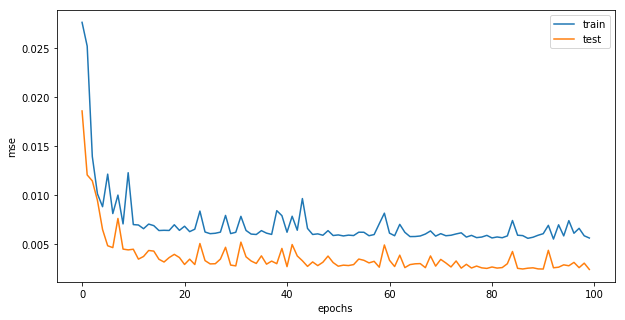

In [56]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

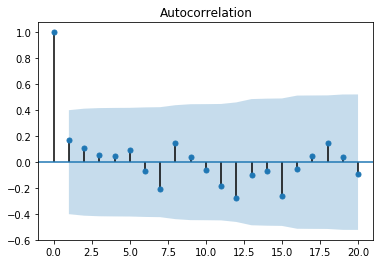

In [57]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## Fort complex model

In [58]:
delay=complex_fort_model_result.head(1)['delay'].values[0]
neuron=complex_fort_model_result.head(1)['neuron'].values[0]
train_size=complex_fort_model_result.head(1)['btch_sz'].values[0]
drpout=complex_fort_model_result.head(1)['drpout'].values[0]

In [59]:
checkpoint=torch.load(MODELS_DIR+'\\complex_fort_model_{}_{}_{}_{}.t7'.format(delay, neuron, train_size, drpout))

net=Net(1, delay, neuron, drpout).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

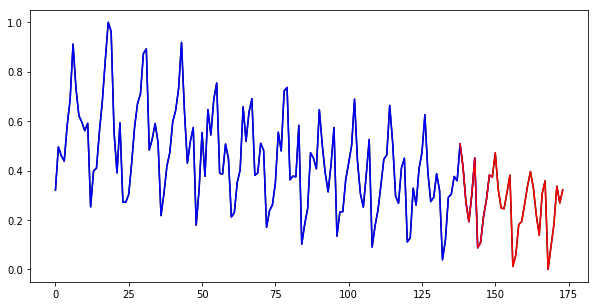

150 36


In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(Fort, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

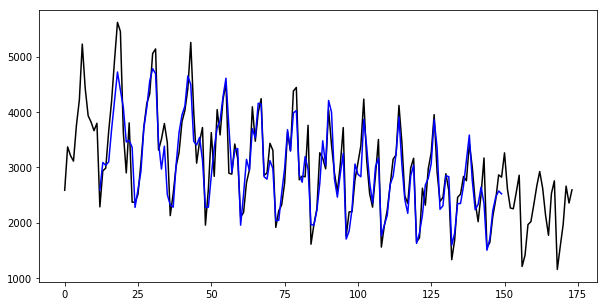

In [61]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

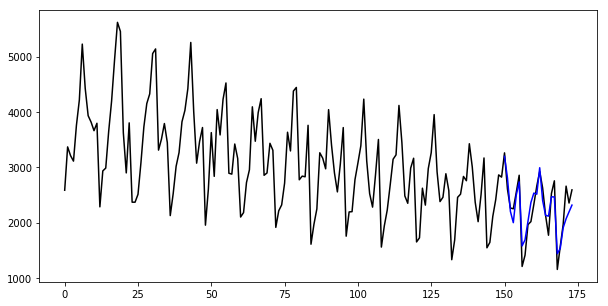

In [62]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[train_size:len(Fort)],testPredict, 'b')
plt.show()

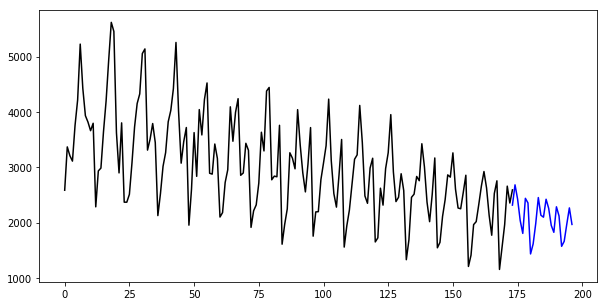

In [63]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
plt.show()

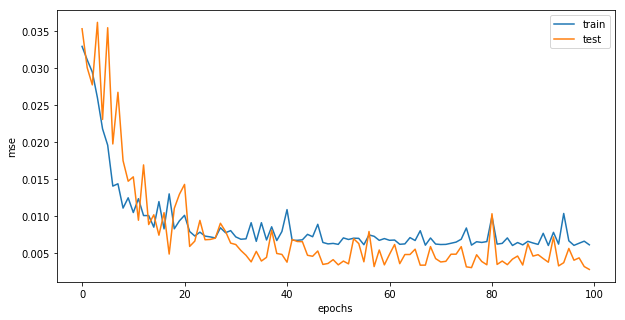

In [64]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

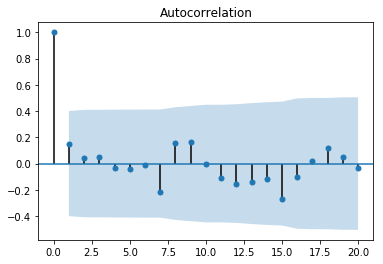

In [65]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## Fort trendless simple model

In [66]:
delay=simple_fort_trendless_model_result.head(1)['delay'].values[0]
neuron=simple_fort_trendless_model_result.head(1)['neuron'].values[0]
train_size=simple_fort_trendless_model_result.head(1)['btch_sz'].values[0]

In [67]:
checkpoint=torch.load(MODELS_DIR+'\\simple_fort_trendless_model_{}_{}_{}.t7'.format(delay,neuron,train_size))

net=Net(1, delay, neuron).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

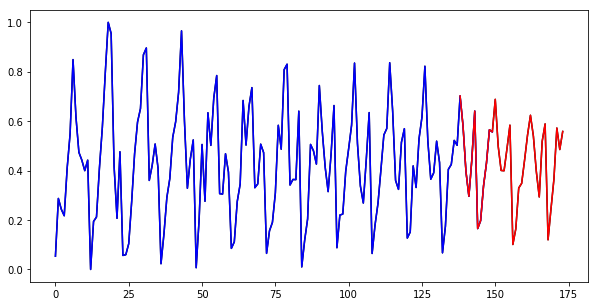

150 36


In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_trendless, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

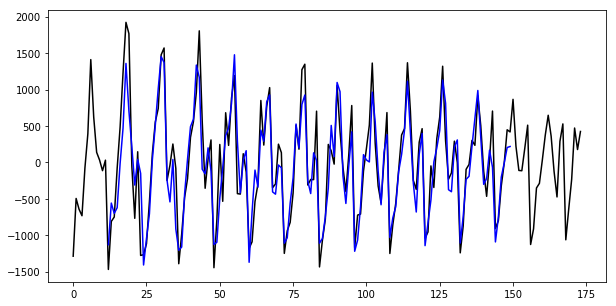

In [69]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

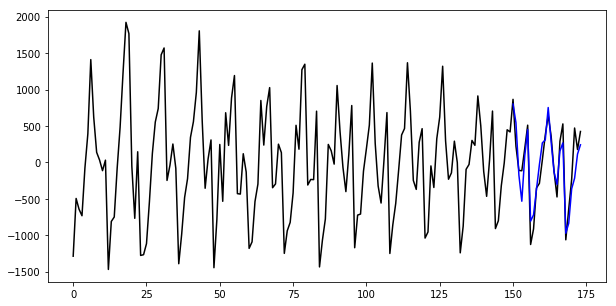

In [70]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[train_size:len(F_trendless)],testPredict, 'b')
plt.show()

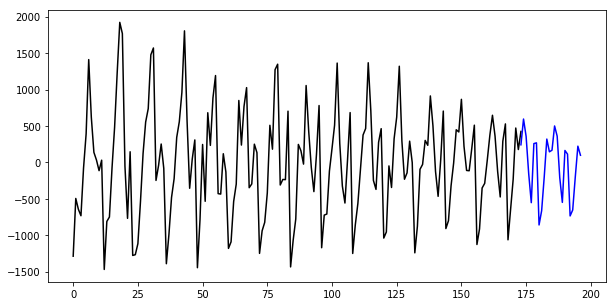

In [71]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[len(F_trendless)-1:len(F_trendless)+24-1],forecastPredict, 'b')
plt.show()

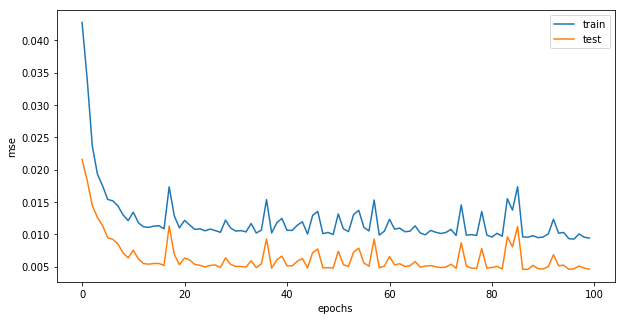

In [72]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

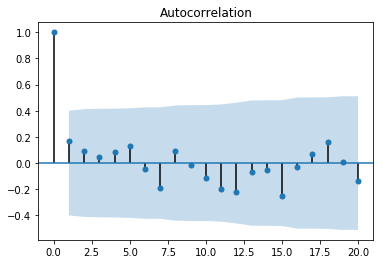

In [73]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## Fort trendless complex model

In [114]:
delay=complex_fort_trendless_model_result.head(1)['delay'].values[0]
neuron=complex_fort_trendless_model_result.head(1)['neuron'].values[0]
train_size=complex_fort_trendless_model_result.head(1)['btch_sz'].values[0]
drpout=complex_fort_trendless_model_result.head(1)['drpout'].values[0]

In [115]:
checkpoint=torch.load(MODELS_DIR+'\\complex_fort_trendless_model_{}_{}_{}_{}.t7'.format(delay,neuron,train_size,drpout))

net=Net(1, delay, neuron,drpout).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

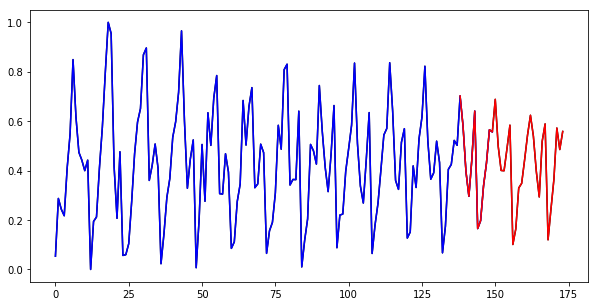

150 36


In [116]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_trendless, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

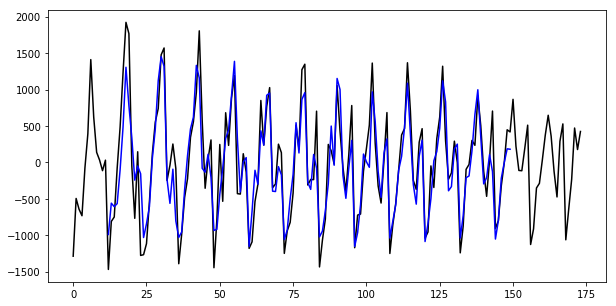

In [117]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

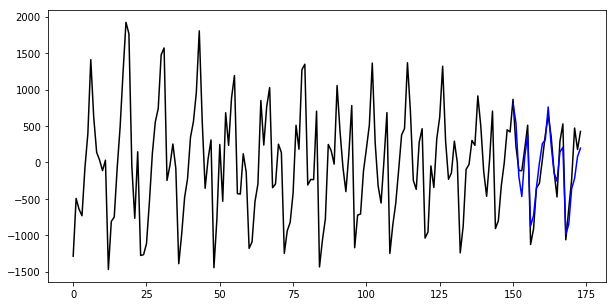

In [118]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[train_size:len(F_trendless)],testPredict, 'b')
plt.show()

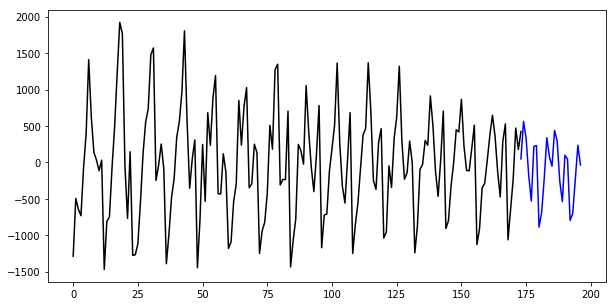

In [122]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_trendless, 'k')
plt.plot(np.r_[len(F_trendless)-1:len(F_trendless)+24-1],forecastPredict, 'b')
plt.show()

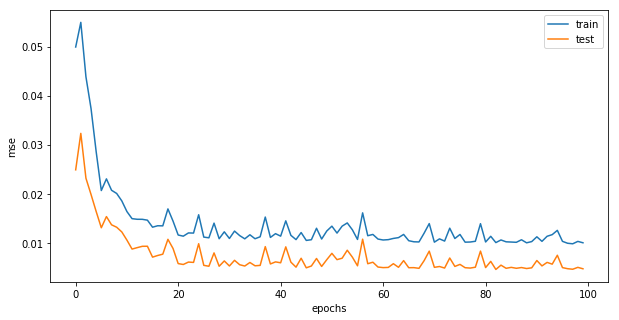

In [123]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

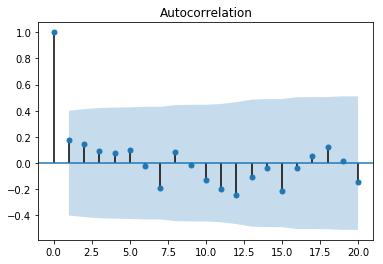

In [124]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## Lab simple model

In [98]:
delay=simple_lab_model_result.head(1)['delay'].values[0]
neuron=simple_lab_model_result.head(1)['neuron'].values[0]
train_size=simple_lab_model_result.head(1)['btch_sz'].values[0]

In [99]:
checkpoint=torch.load(MODELS_DIR+'\\simple_lab_model_{}_{}_{}.t7'.format(delay,neuron,train_size))

net=Net(1, delay, neuron).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

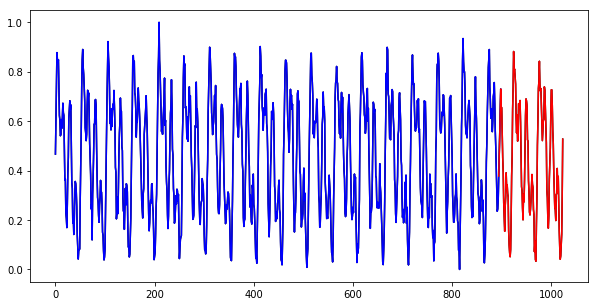

900 130


In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_lab, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

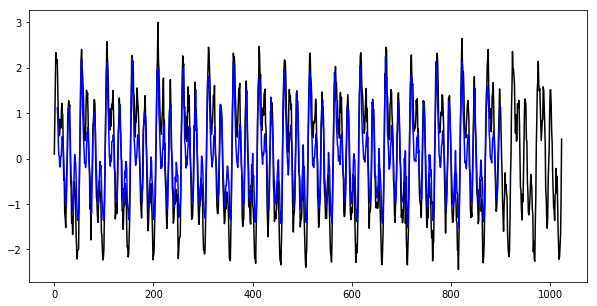

In [101]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

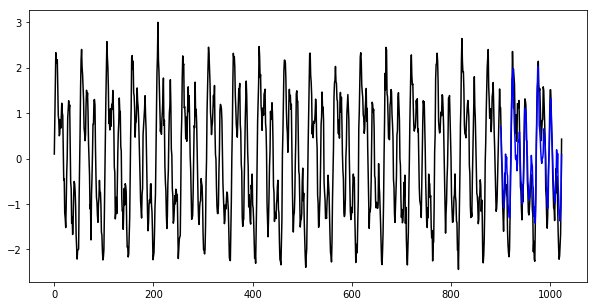

In [102]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[train_size:len(F_lab)],testPredict, 'b')
plt.show()

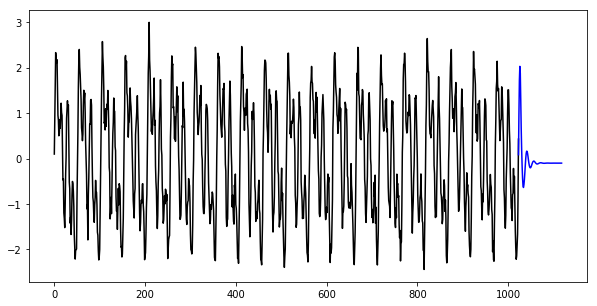

In [103]:
for_forecast=96
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(for_forecast):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[len(F_lab)-1:len(F_lab)+for_forecast-1],forecastPredict, 'b')
plt.show()

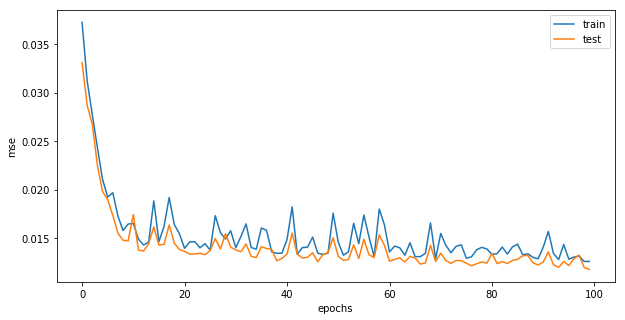

In [104]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

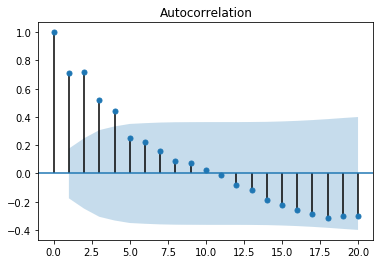

In [105]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## Lab complex model

In [106]:
delay=complex_lab_model_result.head(1)['delay'].values[0]
neuron=complex_lab_model_result.head(1)['neuron'].values[0]
train_size=complex_lab_model_result.head(1)['btch_sz'].values[0]
drpout=complex_lab_model_result.head(1)['drpout'].values[0]

In [107]:
checkpoint=torch.load(MODELS_DIR+'\\complex_lab_model_{}_{}_{}_{}.t7'.format(delay,neuron,train_size,drpout))

net=Net(1, delay, neuron, drpout).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

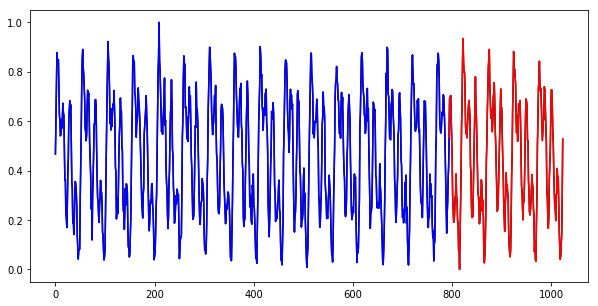

800 230


In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_lab, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

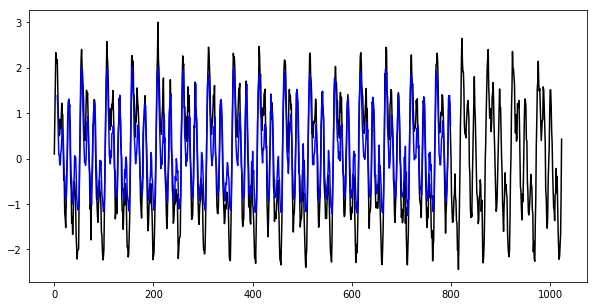

In [109]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

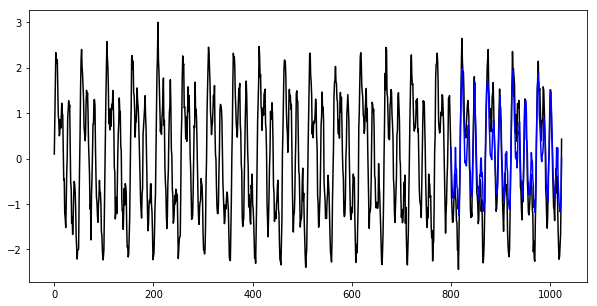

In [110]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[train_size:len(F_lab)],testPredict, 'b')
plt.show()

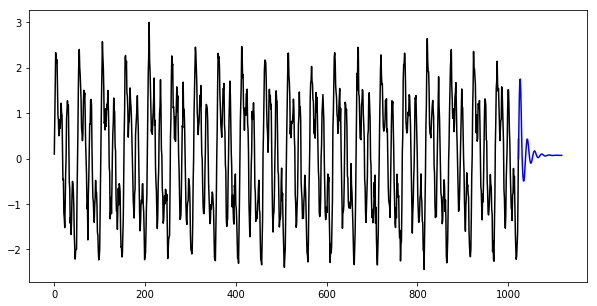

In [111]:
for_forecast=96
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(for_forecast):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[len(F_lab)-1:len(F_lab)+for_forecast-1],forecastPredict, 'b')
plt.show()

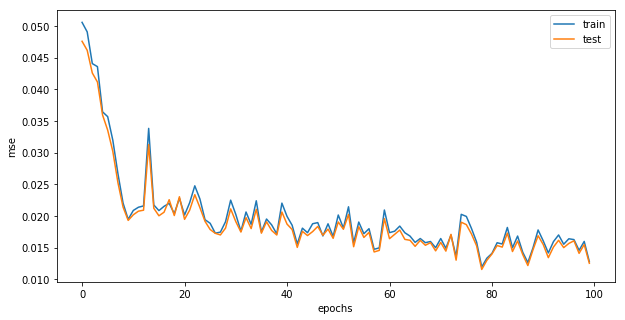

In [112]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

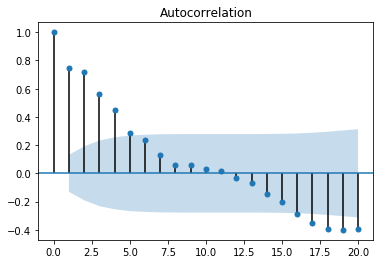

In [113]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

# Keras 

In [ ]:
model = Sequential() # слои соединены последовательно
model.add(LSTM(units=20, input_shape=(1, 6))) # 20 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

In [ ]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

In [ ]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

In [ ]:
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

In [ ]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

In [ ]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

In [ ]:
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()